In [1]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output


# 1.数据初步处理

首先载入数据并观察数据集的大小

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
test_ID = test_data['Id']

y_train = train_data['SalePrice']
combine_data = pd.concat((train_data,test_data)).reset_index(drop=True)
combine_data.drop(['SalePrice','Id'],axis=1,inplace=True)
object_col = combine_data.dtypes[combine_data.dtypes=='object'].index
numeric_col = combine_data.dtypes[combine_data.dtypes!='object'].index
missing_col = combine_data.isnull().sum()[combine_data.isnull().sum()>0].index
print("数据共有",combine_data.shape[1],"列,",combine_data.shape[0],"行\n")
print("训练集有",train_data.shape[0],'行',"测试集有",test_data.shape[0],"行\n")
print("object数据共有",combine_data.dtypes[combine_data.dtypes=='object'].value_counts().sum(),"列\n")
print("非object数据共有",combine_data.dtypes[combine_data.dtypes!='object'].value_counts().sum(),"列\n")



数据共有 79 列, 2919 行

训练集有 1460 行 测试集有 1459 行

object数据共有 43 列

非object数据共有 36 列



可以看到，数据中训练集和测试集规模相等，都是1460行左右，其中有36列是数字数据，43列是字符串数据。接下来查看一下缺失数据情况

In [3]:
print(pd.DataFrame({"missing ratio":combine_data.isnull().sum()[combine_data.isnull().sum()>0]
                    .sort_values(ascending=False)/combine_data.shape[0]}))



              missing ratio
PoolQC                0.997
MiscFeature           0.964
Alley                 0.932
Fence                 0.804
FireplaceQu           0.486
LotFrontage           0.166
GarageQual            0.054
GarageCond            0.054
GarageFinish          0.054
GarageYrBlt           0.054
GarageType            0.054
BsmtExposure          0.028
BsmtCond              0.028
BsmtQual              0.028
BsmtFinType2          0.027
BsmtFinType1          0.027
MasVnrType            0.008
MasVnrArea            0.008
MSZoning              0.001
BsmtFullBath          0.001
BsmtHalfBath          0.001
Utilities             0.001
Functional            0.001
Electrical            0.000
BsmtUnfSF             0.000
Exterior1st           0.000
Exterior2nd           0.000
TotalBsmtSF           0.000
GarageArea            0.000
GarageCars            0.000
BsmtFinSF2            0.000
BsmtFinSF1            0.000
KitchenQual           0.000
SaleType              0.000


In [4]:
print("有",combine_data.isnull().sum()[combine_data.isnull().sum()>0].shape[0],"列数据出现缺失\n")
print(pd.DataFrame({"missing ratio":combine_data.isnull().sum()[combine_data.isnull().sum()>0]
                    .sort_values(ascending=False)/combine_data.shape[0]}))

有 34 列数据出现缺失

              missing ratio
PoolQC                0.997
MiscFeature           0.964
Alley                 0.932
Fence                 0.804
FireplaceQu           0.486
LotFrontage           0.166
GarageQual            0.054
GarageCond            0.054
GarageFinish          0.054
GarageYrBlt           0.054
GarageType            0.054
BsmtExposure          0.028
BsmtCond              0.028
BsmtQual              0.028
BsmtFinType2          0.027
BsmtFinType1          0.027
MasVnrType            0.008
MasVnrArea            0.008
MSZoning              0.001
BsmtFullBath          0.001
BsmtHalfBath          0.001
Utilities             0.001
Functional            0.001
Electrical            0.000
BsmtUnfSF             0.000
Exterior1st           0.000
Exterior2nd           0.000
TotalBsmtSF           0.000
GarageArea            0.000
GarageCars            0.000
BsmtFinSF2            0.000
BsmtFinSF1            0.000
KitchenQual           0.000
SaleType              0.000


由以上可以看到，79列数据中近半是有缺失值的，大部分缺失值都在10%以下，这些缺失值可以通过各种手段进行处理。而有5列数据缺失值接近或超过了50%。分别是
>* PoolQC 游泳池情况，取值有Excellent，Good，Fair，空值表示没有游泳池。
>* MiscFeature 房屋有的其他设施，取值有Shed(小屋)，Othr(其他)，Gar2(第二个车库)，TenC(乒乓球桌)，空值代表没有其他设施
>* Alley 小巷道路类型，取值有Grvl（碎石），paved(铺切面)。空值代表没有小巷
>* Fence 围墙类型，取值有GdPrv(Good Privacy)，MnPrv（Minimum Privacy），GdWo（Good Wood），MnWw（Minimum Wood），空值代表没有围墙
>* FireplaceQu 壁炉类型，取值有Ex(Excellent),Gd(Good),Fa(Fair),Po(Poor),TA(Average),空值代表没有壁炉。

对于这些列，空值是有特别意义的，因此将空值赋予None字符串

In [5]:
combine_data['PoolQC'].fillna("None",inplace=True)
combine_data['MiscFeature'].fillna("None",inplace=True)
combine_data['Alley'].fillna("None",inplace=True)
combine_data['Fence'].fillna("None",inplace=True)
combine_data['FireplaceQu'].fillna("None",inplace=True)

下边继续查看包含缺失值的列
>* LotFrontage Linear feet of street connected to property 应该是房屋与大街的连接距离，缺失数据可以尝试用其他关联性高的列进行填充,有选手认为在该房屋附近的其他房子应该有一样的连接距离，因此可以用Neighborhood来的关系来填充此值
>* Garage\* 以下5列缺失比例是一样的，分别是车库的信息，如果缺失的话证明该房子不包含车库。因此可以用None或0来填充
>* Bsmt\* 以下5列缺失比例也是几乎一样，分别是地下室的信息，如果缺失的话证明该房子不包含地下室，因此可以用None或0填充
>* MasVnr\* 墙面结构和面积，空值表示没有墙面结构

In [6]:
combine_data['LotFrontage']=combine_data.groupby(['Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

combine_data['GarageQual'].fillna("None",inplace=True)
combine_data['GarageCond'].fillna("None",inplace=True)
combine_data['GarageFinish'].fillna("None",inplace=True)
combine_data['GarageYrBlt'].fillna(0,inplace=True)
combine_data['GarageType'].fillna("None",inplace=True)

combine_data['BsmtQual'].fillna("None",inplace=True)
combine_data['BsmtExposure'].fillna("None",inplace=True)
combine_data['BsmtCond'].fillna("None",inplace=True)
combine_data['BsmtFinType1'].fillna("None",inplace=True)
combine_data['BsmtFinSF1'].fillna(0,inplace=True)
combine_data['BsmtFinType2'].fillna("None",inplace=True)
combine_data['BsmtFinSF2'].fillna(0,inplace=True)
combine_data['BsmtFullBath'].fillna(0,inplace=True)
combine_data['BsmtHalfBath'].fillna(0,inplace=True)
combine_data['BsmtUnfSF'].fillna(0,inplace=True)
combine_data['TotalBsmtSF'].fillna(0,inplace=True)

combine_data['MasVnrType'].fillna("None",inplace=True)
combine_data['MasVnrArea'].fillna(0,inplace=True)



In [7]:
print(combine_data.isnull().sum()[combine_data.isnull().sum()>0].sort_values(ascending=False)/combine_data.shape[0])

MSZoning      0.001
Utilities     0.001
Functional    0.001
SaleType      0.000
KitchenQual   0.000
GarageCars    0.000
GarageArea    0.000
Exterior2nd   0.000
Exterior1st   0.000
Electrical    0.000
dtype: float64


接下来填充剩余的空值

MSZoning应该是房屋所属用途，空值有4个，取值最多的是RL，因此可以简单填充空值为RL

In [8]:
combine_data['MSZoning'].fillna("RL",inplace=True)

Utilities取值几乎全是一样，只有一个值例外，这一列对数据拟合不会起用途，因此将其删除

In [9]:
del combine_data['Utilities']

Functional是房屋的功能，其取值最多是Typ，空值有2个，填充Typ即可

In [10]:
combine_data['Functional'].fillna("Typ",inplace=True)

SellType是房屋付款方式，只有1个空值，填充最多的WD即可

In [11]:
combine_data['SaleType'].fillna("WD",inplace=True)

KitchenQual厨房情况，1个空值，填充最多的TA即可

In [12]:
combine_data['KitchenQual'].fillna("TA",inplace=True)

GarageCars,GarageArea是车库信息，空值可以认为没有车库，因此填充0值即可

In [13]:
combine_data['GarageCars'].fillna(0,inplace=True)
combine_data['GarageArea'].fillna(0,inplace=True)

Exterior1st,Exterior2nd是外墙材料，空值填充最多VinylSd即可

In [14]:
combine_data['Exterior1st'].fillna("VinylSd",inplace=True)
combine_data['Exterior2nd'].fillna("VinylSd",inplace=True)

Electrical是电力系统，空值填充最多的SBrkr即可

In [15]:
combine_data['Electrical'].fillna("SBrkr",inplace=True)

In [16]:
print("有",combine_data.isnull().sum()[combine_data.isnull().sum()>0].shape[0],"列数据出现缺失")


有 0 列数据出现缺失


空值数据已经填充完毕，可以开始下一步工作了

# 2. 数据可视化

In [17]:
train_data = combine_data[:train_data.shape[0]]
test_data = combine_data[train_data.shape[0]:]
train_data = pd.concat((train_data,y_train),axis=1)

## 2.1标签的分布
因为题目要求要预测房屋的销售价格SalePrice，因此首先我们要先查看一下其分布

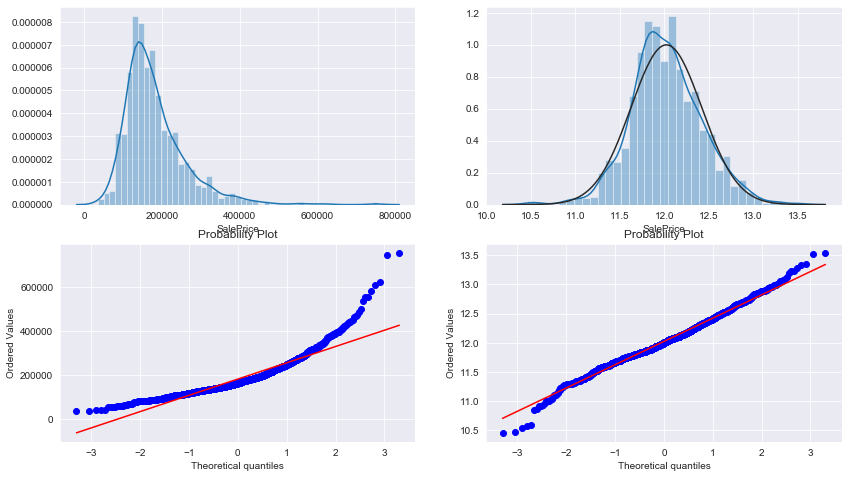

In [18]:
#左边两图，SalePrice的分布以及QQ图
#右边两图，log(SalePrice)的分布及QQ图
#取对数后更趋向正态分布
fig = plt.figure(figsize=(14,8))
plt.subplot2grid((2,2),(0,0))
sns.distplot((train_data['SalePrice']))

plt.subplot2grid((2,2),(0,1))
sns.distplot(np.log((train_data['SalePrice'])),fit=norm)

plt.subplot2grid((2,2),(1,0))
res = stats.probplot(train_data['SalePrice'], plot=plt)

plt.subplot2grid((2,2),(1,1))
res = stats.probplot(np.log(train_data['SalePrice']), plot=plt)
      

In [19]:
np.log(train_data['SalePrice']).skew()

0.12133506220520406

上图左边部分绘制了SalePrice的分布，可以看到是一个左高右低的分布，说明销售价格集中于某个区域，左下角绘制的QQ图也显示其与正态分布偏离颇大。
因此右上角图尝试绘制了SalePrice的对数分布图，以及对应右下角的QQ图，此图拟合形状接近直线也证明对销售价格取对数后，其接近正态分布。所以在分析完SalePrice与其它变量的分布后，会对其取对数。

## 2.2 数值型数据的关联
下一步绘制一下各变量关联性的热力图以及变量与标签SalePrice的关联分布

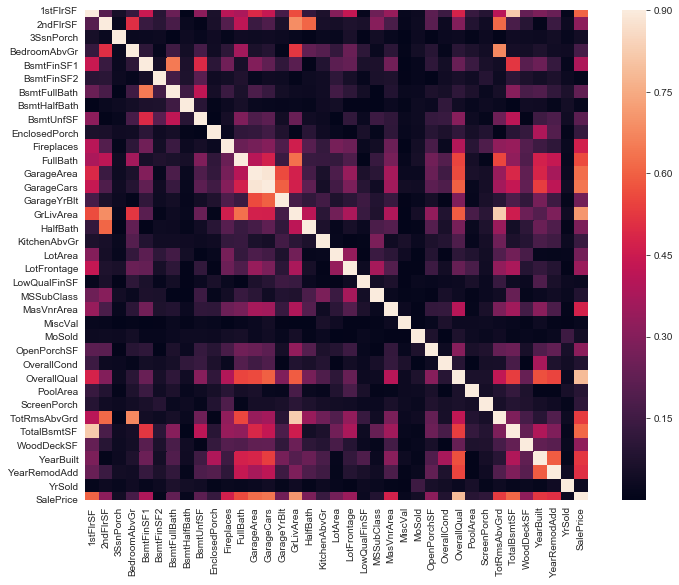

In [20]:
corrmat = abs(train_data.corr())
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 <a list of 7 Text yticklabel objects>)

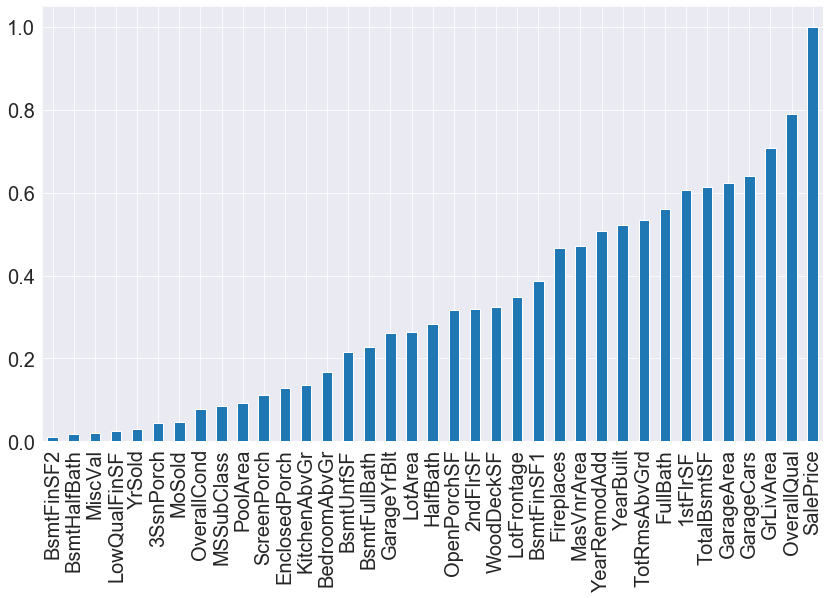

In [21]:
fig = plt.figure(figsize=(14,8))
abs(train_data.corr()['SalePrice']).sort_values(ascending=True).plot.bar()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

因为有些变量跟标签SalePrice的相关系数是负数，因此取绝对值来更有效地观察其与标签的关联性。可以看到有十多个变量与标签的相关系数是大于0.5。如
>* 1.OverallQual 房屋设施的完整性
>* 2.GrLivArea 居住面积
>* 3.4 GarageCars GarageArea 车库容量，看来老外很看重车库，因为人人有车
>* 5.TotalBsmtSF 地下室大小
>* 6.1stFlrSF 1楼面积
>* 7.FullBath 厕所数量
>* 8.TotRmsAbvGrd 地面上的房间数量
>* 9.YearBuilt 建造年份
>* 10.YearRemodAdd 重建年份

其他变量关联性没有太高，不一一列出了，着重看一下前10个的分布。
首先是OverallQual房屋设施的完整性

Text(0, 0.5, 'SalePrice')

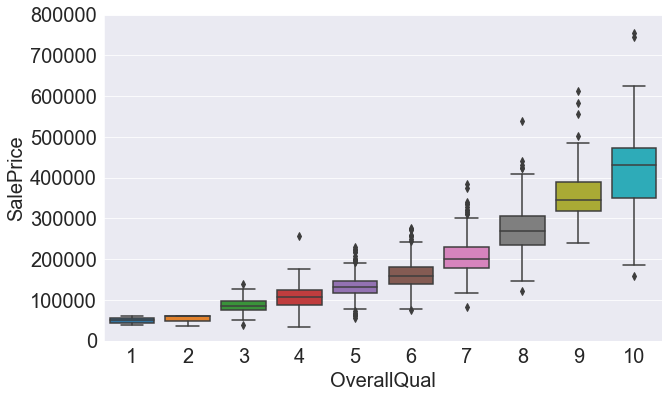

In [22]:
fig = plt.figure(figsize=(10,6))

fig = sns.boxplot(x="OverallQual", y="SalePrice", data=train_data[['SalePrice','OverallQual']])
fig.axis(ymin=0, ymax=800000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("OverallQual",fontsize=20)
plt.ylabel("SalePrice",fontsize=20)

参考了一下其他人的代码，发现sns的箱图能够很好表达这种离散数据的分布。每个箱子中线就是中位数A，箱子边缘就是两个四分位数B和C，而线的两个末端D(上端点)和E(下端点)，是两个四分位数值差的1.5倍，也就是，D = 1.5\*(B-C)+B $\quad$ E = C-(1.5\*(B-C)),在这些值之外的，可以被认为是outlier。详细定义可以参考维基百科https://zh.wikipedia.org/wiki/%E7%AE%B1%E5%BD%A2%E5%9C%96

从上图很容易可以看出，OverallQual越高，房屋价格越高

下边看一下GrLivArea居住面积与销售价格的关系

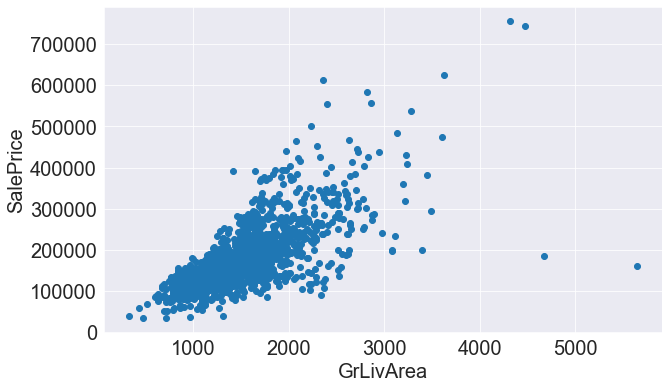

In [23]:
fig = plt.figure(figsize=(10,6))
plt.scatter(x=train_data['GrLivArea'],y=train_data['SalePrice'])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("GrLivArea",fontsize=20)
plt.ylabel("SalePrice",fontsize=20)
plt.show()


上图可以看到，居住面积与销售价格具有很强烈的正相关。但是样本中也有两个右下角离群点，这两个离群点可能会对数据拟合不利，所以有些人会把这两个点去掉，在最后的处理中，发现这两个离群点对误差的影响相当大，因此首先在这里去掉

In [24]:
#以下这一项对误差影响相当大
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<300000)].index)

接下来查看车库容量和面积对销售价格的影响

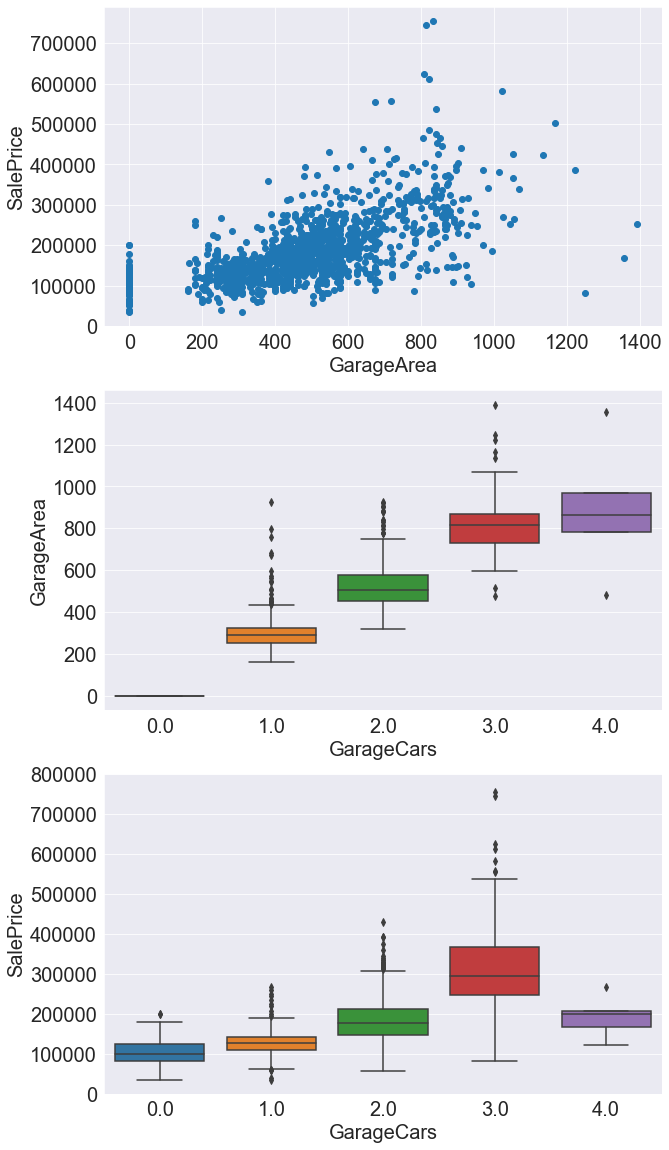

In [25]:
#fig = plt.figure(figsize=(20,10))
plt.figure(figsize=(10,20))
#plt.subplots_adjust(wspace =0.5, hspace =0.5)#调整子图间距
plt.subplot(311)

plt.scatter(x=train_data['GarageArea'],y=train_data['SalePrice'])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("GarageArea",fontsize=20)
plt.ylabel("SalePrice",fontsize=20)

plt.subplot(312)
fig1 = sns.boxplot(x='GarageCars', y="GarageArea", data=train_data[['GarageArea','GarageCars']])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("GarageCars",fontsize=20)
plt.ylabel("GarageArea",fontsize=20)

plt.subplot(313)
fig = sns.boxplot(x='GarageCars', y="SalePrice", data=train_data[['SalePrice','GarageCars']])
fig.axis(ymin=0, ymax=800000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("GarageCars",fontsize=20)
plt.ylabel("SalePrice",fontsize=20)
plt.show()


上边分布画了车库容量和面积分布与销售价格的对比，以及车库容量和面积之间的对比。可以看到车库面积越大销售价格也是越贵的(当然也有几个离群点)。

而车库容量在0-3时，容量越大销售价格也是越高，但是容量为4时价格反而变低了，可能是因为不好卖了，因为容量太大也没有太多车放。

而车库容量与车库面积当然是成正比关系，但是箱图中的离群点还是挺多的。

下边查看地下室面积、1楼面积、厕所数量，房间数量如销售价格的关系

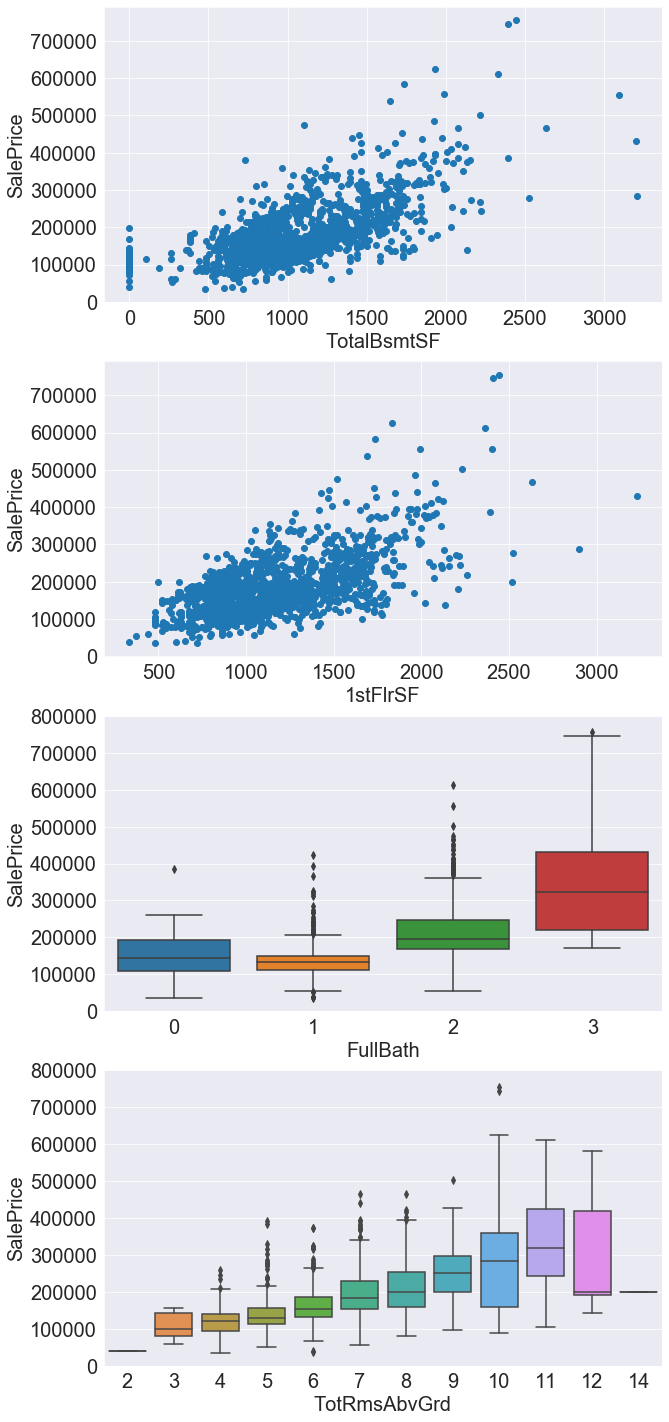

In [26]:
#fig = plt.figure(figsize=(20,10))
plt.figure(figsize=(10,25))
#plt.subplots_adjust(wspace =0.5, hspace =0.5)#调整子图间距
plt.subplot(411)

plt.scatter(x=train_data['TotalBsmtSF'],y=train_data['SalePrice'])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("TotalBsmtSF",fontsize=20)
plt.ylabel("SalePrice",fontsize=20)

plt.subplot(412)

plt.scatter(x=train_data['1stFlrSF'],y=train_data['SalePrice'])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("1stFlrSF",fontsize=20)
plt.ylabel("SalePrice",fontsize=20)

plt.subplot(413)
fig = sns.boxplot(x='FullBath', y="SalePrice", data=train_data[['SalePrice','FullBath']])
fig.axis(ymin=0, ymax=800000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("FullBath",fontsize=20)
plt.ylabel("SalePrice",fontsize=20)

plt.subplot(414)
fig = sns.boxplot(x='TotRmsAbvGrd', y="SalePrice", data=train_data[['SalePrice','TotRmsAbvGrd']])
fig.axis(ymin=0, ymax=800000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("TotRmsAbvGrd",fontsize=20)
plt.ylabel("SalePrice",fontsize=20)
plt.show()

从两个面积的散点图可以看到，地下室和地上面积越大，销售价格越高。而且都存在数个离群点，特别是有一个面积特别大但是销售价格只有十多万的一个数据，同一个异常数据在很多列都出现了，这对最后的拟合很大可能会造成影响，因此我们决定还是把它去掉。

In [27]:
train_data = train_data[train_data['1stFlrSF']<4000]

最后看一下建造年份和维修年份对价格的影响

Text(0, 0.5, 'SalePrice')

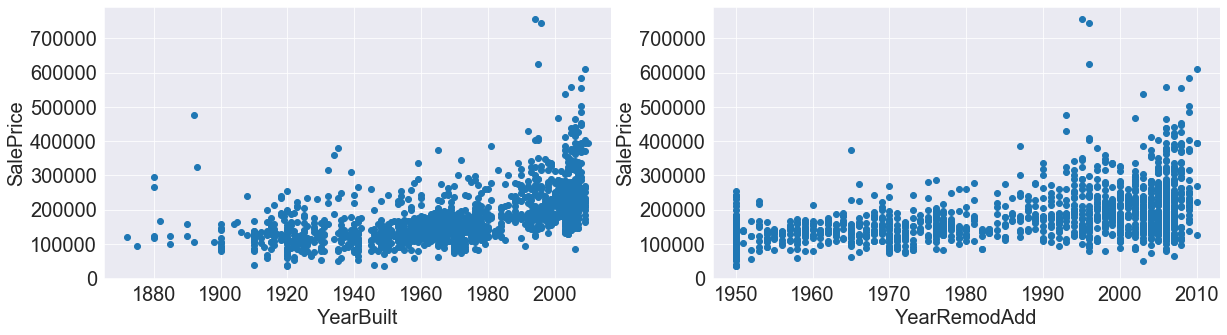

In [28]:
#fig = plt.figure(figsize=(20,10))
plt.figure(figsize=(20,5))
#plt.subplots_adjust(wspace =0.5, hspace =0.5)#调整子图间距
plt.subplot(121)

plt.scatter(x=train_data['YearBuilt'],y=train_data['SalePrice'])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("YearBuilt",fontsize=20)
plt.ylabel("SalePrice",fontsize=20)

plt.subplot(122)

plt.scatter(x=train_data['YearRemodAdd'],y=train_data['SalePrice'])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("YearRemodAdd",fontsize=20)
plt.ylabel("SalePrice",fontsize=20)



虽然不太明显，但是也可以看出建造或者重建年份越高的，价格越高。另外有些房子建造年份是1880年福建的，但是价格也卖得不错，应该是因为在后边重建过导致。

#### 数值型数据观察总结
查看数个数值型变量的分布后发现，对于离散型变量，问题并不大，但是对于连续型变量，是有可能存在一些离群点，并且数据集中在某个区域的情况比较多，也就是说Skewness偏度比较高。后期可以对偏度较高的数据去对数来尝试将其恢复为正态分布，看能否提升准确度。

## 2.3 非数值型数据的关联
对于非数值型数据,需要将其转变为离散型变量才可以处理，所以先用sklearn里内置的模块处理一下

In [29]:
from sklearn.preprocessing import LabelEncoder
train_shape = train_data.shape[0]
combine_data = pd.concat((train_data,test_data))
cols = combine_data.dtypes[combine_data.dtypes=='object'].index
for col in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(combine_data[col].values)) 
    combine_data[col] = lbl.transform(list(combine_data[col].values))
train_data = combine_data[:train_shape]
test_data = combine_data[train_shape:]

cols = list(cols)
cols.append("SalePrice")

处理完毕后看一下各个变量之间关联性的热力图

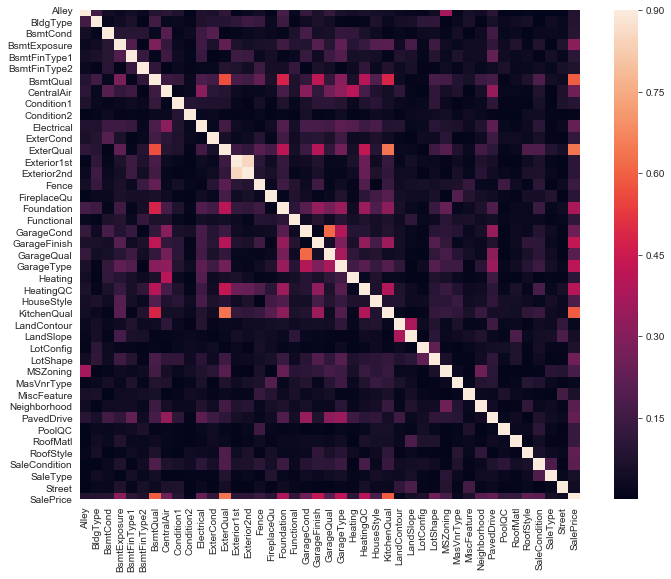

In [30]:
corrmat = abs(train_data[cols].corr())
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 <a list of 7 Text yticklabel objects>)

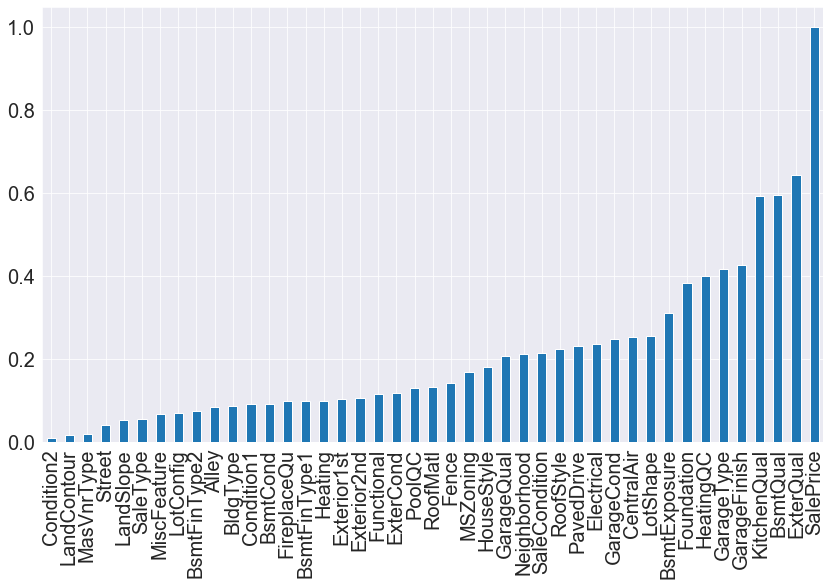

In [31]:
fig = plt.figure(figsize=(14,8))
abs(train_data[cols].corr()['SalePrice']).sort_values(ascending=True).plot.bar()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

可以看到这些离散数据与SalePrice的相关性没有之前的那么大，相关性高于50%的有KitchenQual（厨房质量）BsmtQual(地下室质量)，ExterQual(外墙质量)。下边就看看这3个变量的分布。

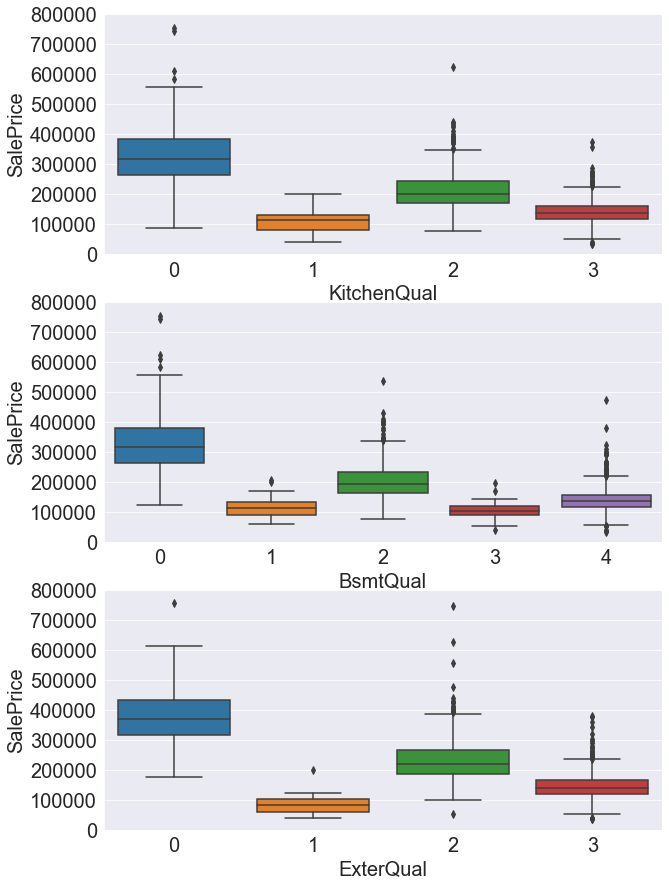

In [32]:
#fig = plt.figure(figsize=(20,10))
plt.figure(figsize=(10,15))
#plt.subplots_adjust(wspace =0.5, hspace =0.5)#调整子图间距
plt.subplot(311)

fig = sns.boxplot(x='KitchenQual', y="SalePrice", data=train_data[['SalePrice','KitchenQual']])
fig.axis(ymin=0, ymax=800000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("KitchenQual",fontsize=20)
plt.ylabel("SalePrice",fontsize=20)

plt.subplot(312)

fig = sns.boxplot(x='BsmtQual', y="SalePrice", data=train_data[['SalePrice','BsmtQual']])
fig.axis(ymin=0, ymax=800000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("BsmtQual",fontsize=20)
plt.ylabel("SalePrice",fontsize=20)

plt.subplot(313)
fig = sns.boxplot(x='ExterQual', y="SalePrice", data=train_data[['SalePrice','ExterQual']])
fig.axis(ymin=0, ymax=800000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("ExterQual",fontsize=20)
plt.ylabel("SalePrice",fontsize=20)

plt.show()

这三个Quaility变量取值是从差到好（Poor，Fair，Average，Good，Excellent），但是映射到数字的时候并没有从小到大排序，但是也可以看到，售价与这几个变量的取值存在相关性，质量越好的售价肯定就越高了。

#### 非数值型数据观察小结
对于非数值型数据，我们可以用sklearn内置的LableEncoder来对其编码，编码后就可以观察其与标签的关系，同时也可以参与训练。

编码后发现只有3个指标与销售价格相关性大于50%，其他指标都基本低于40%

# 3.特征工程

观察数据的分布，对其有一定了解之后，需要对特征作进一步处理了。其实上边已经对一些数据进行填充空值、编码等处理。这里的话会对数据进行继续完善。

## 3.1进一步编码
查看发现，数据中有一些特征虽然其内容是数字，但是实际上数字大小并没有实际意义，因此可以将其编码为字符，再用LabelEndcoder来转换其编码。
这里只有一个特征是这种情况：MSSubClass。虽然OverallQual，OverallQual这两列数字（1-10代表从差到好）与其它数值变量含义如面积等变量意义不一样），但是也不用重新编码了。因此这里只对MSubClass进行处理

In [33]:
combine_data['MSSubClass'].astype(str)
lbl = LabelEncoder() 
lbl.fit(list(combine_data['MSSubClass'].values)) 
combine_data['MSSubClass'] = lbl.transform(combine_data['MSSubClass'].values)


## 3.2偏度处理
接下来是对一些偏度过大的数据作一下处理。我们认为当数据偏度为0的时候属于正态分布，这时数据用于拟合是最理想的。查看发现scipy.special.boxcox1p这个函数可以对偏度大的数据作转换。转换方式为$$x^{'}=\frac{x^{\lambda}-1}{\lambda}$$
当$\lambda=0$时，其变换就是$x^{'}=log(x)$,当$\lambda=1$时，就是$x{'}=x-1$。关于这个变换的介绍可以查看http://onlinestatbook.com/2/transformations/box-cox.html
首先查看一下偏度较大的数据

In [34]:
skew=pd.DataFrame({"Skew":abs(combine_data[numeric_col].skew()).sort_values()})
skew_col = skew[abs(skew["Skew"])>0.75]["Skew"].sort_values(ascending=False).index
skew[abs(skew["Skew"])>0.75]["Skew"].sort_values(ascending=False)

MiscVal         21.951
PoolArea        17.698
LotArea         13.116
LowQualFinSF    12.091
3SsnPorch       11.378
KitchenAbvGr     4.303
BsmtFinSF2       4.147
EnclosedPorch    4.004
ScreenPorch      3.947
BsmtHalfBath     3.932
GarageYrBlt      3.907
MasVnrArea       2.623
OpenPorchSF      2.531
WoodDeckSF       1.846
1stFlrSF         1.258
LotFrontage      1.103
GrLivArea        1.069
BsmtFinSF1       0.981
BsmtUnfSF        0.920
2ndFlrSF         0.862
Name: Skew, dtype: float64

可以看到大概有20列数据偏度是大于0.75的。其中有些偏度超过了10,下边先查看一下这些数据的分布。

Text(0.5, 0, 'GrLivArea')

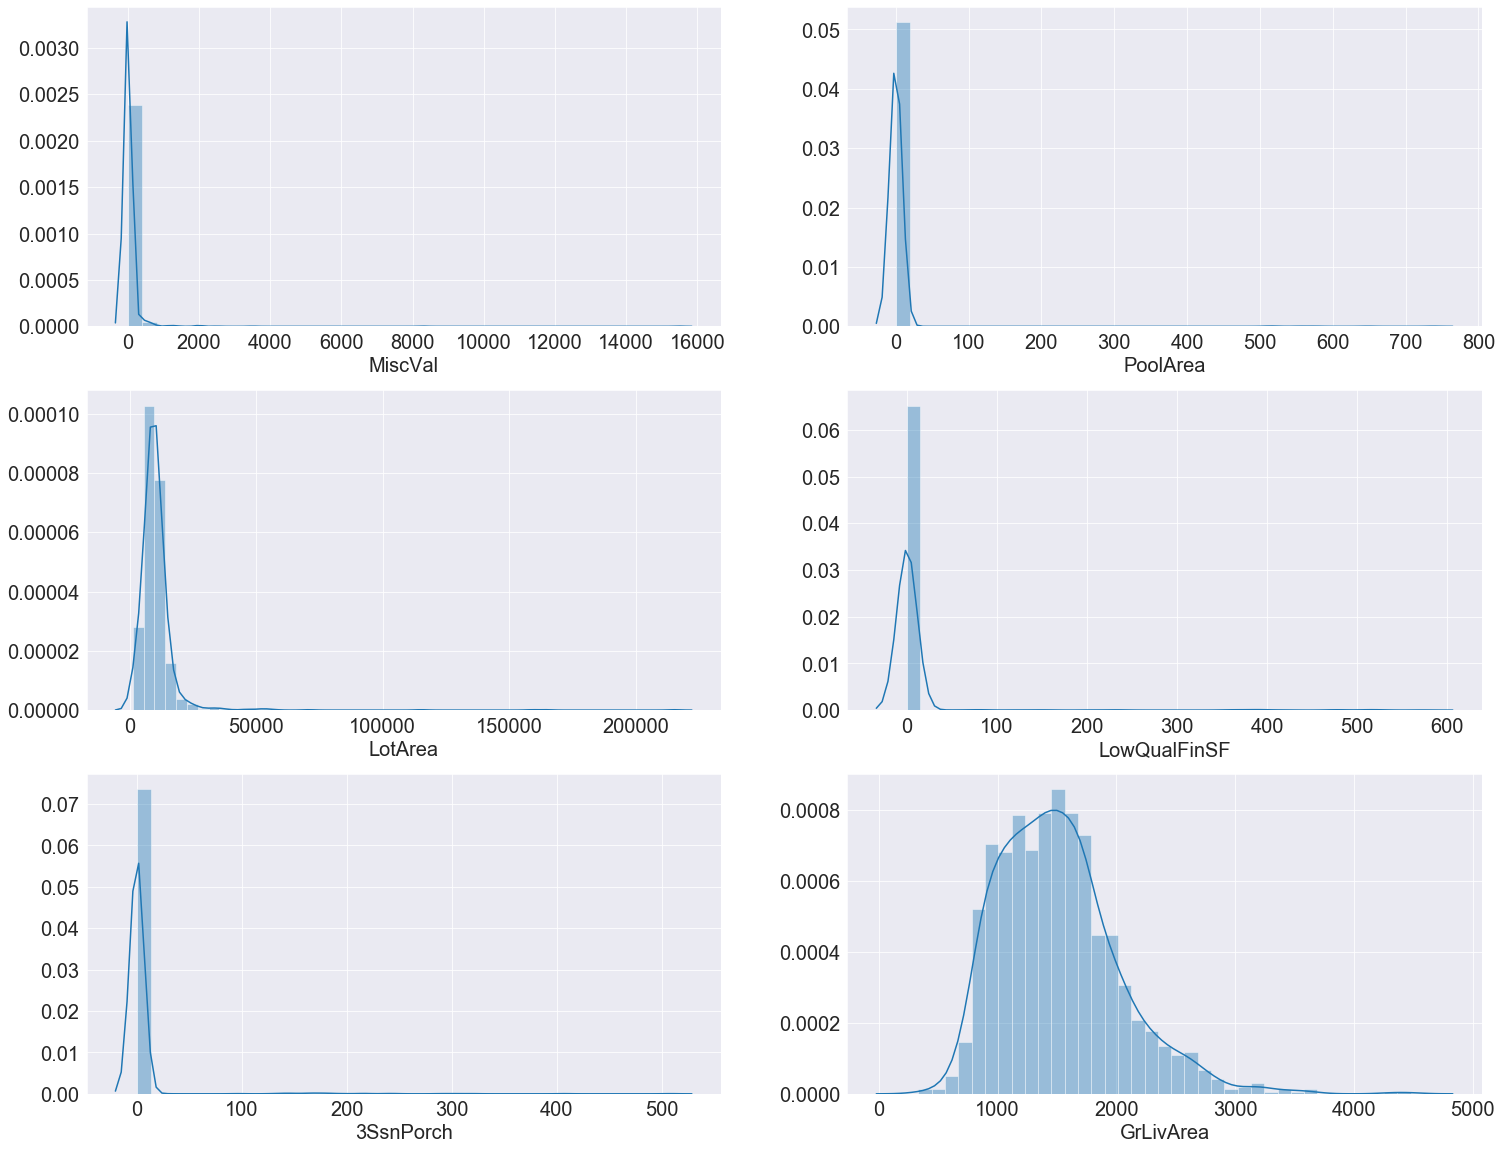

In [35]:
#fig = plt.figure(figsize=(20,10))
plt.figure(figsize=(25,20))
#plt.subplots_adjust(wspace =0.5, hspace =0.5)#调整子图间距

plt.subplot(321)
sns.distplot((train_data['MiscVal']))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("MiscVal",fontsize=20)

plt.subplot(322)
sns.distplot((train_data['PoolArea']))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("PoolArea",fontsize=20)

plt.subplot(323)
sns.distplot((train_data['LotArea']))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("LotArea",fontsize=20)

plt.subplot(324)
sns.distplot((train_data['LowQualFinSF']))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("LowQualFinSF",fontsize=20)

plt.subplot(325)
sns.distplot((train_data['3SsnPorch']))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("3SsnPorch",fontsize=20)

plt.subplot(326)
sns.distplot((train_data['GrLivArea']))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("GrLivArea",fontsize=20)


上图画了5张偏度大于10的特征分布，以及一个偏度为1.1的特征分布。可以看到偏度很高的分布，其原因是很多值都为0，比如PoolArea游泳池面积,LotArea花园面积，如果没有游泳池或花园，这些值就为0。对于这种0值很多的分布，boxcox1p也无法将其还原到正态分布。而对于GrLivArea居住面积这种分布，boxcox1p是有希望将其恢复为正态分布的。下边就试一下。

In [36]:
#combine_data1 = combine_data.copy()


from scipy.special import boxcox1p
lam = 0.15
for feat in skew_col:
    combine_data[feat] = boxcox1p(combine_data[feat], lam)

abs(combine_data[skew_col].skew()).sort_values(ascending=False)


PoolArea        15.768
3SsnPorch        8.926
LowQualFinSF     8.746
MiscVal          5.598
GarageYrBlt      3.926
BsmtHalfBath     3.789
KitchenAbvGr     3.699
ScreenPorch      2.979
BsmtFinSF2       2.565
EnclosedPorch    2.025
BsmtUnfSF        1.538
LotFrontage      0.800
MasVnrArea       0.638
BsmtFinSF1       0.489
2ndFlrSF         0.329
WoodDeckSF       0.224
1stFlrSF         0.179
LotArea          0.178
GrLivArea        0.130
OpenPorchSF      0.099
dtype: float64

测试几个值之后发现$\lambda$取0的时候效果是最好的，可以看到除了PoolArea外其他分布的偏度都低于10了，几乎所有的分布偏度都有所减少。当然实际使用时最好的方法大概是应该针对每个特征都测试不同的$\lambda$，分别取最好的值来进行处理。

## 3.3离散值处理
下一步处理一下离散值，之前我们已经将离散值进行编码处理，但是对于大部分离散值，它们每一个取值直接都是独立的，没有大小关系。因此可以用pandas的get_dummies来对离散值进行one-hot处理。但是这样做得很有可能会带来两个问题：1.此处离散值太多，都进行one-hot处理的话会造成特征稀疏。2.有些离散值之间其实是有大小关系的，比如BsmtCond，BsmtQual等这些描述房屋某个设施的质量等级。之后的话可以针对这些情况作更精细的调整。

In [37]:

for col in cols:
    if(col=='SalePrice'):continue
    combine_data[col]=combine_data[col].apply(str)

combine_data = pd.get_dummies(combine_data)
combine_data.shape


(2917, 300)

好了数据终于处理完毕，接下来是构建模型的时候了。为了让最终的结果更加健壮，这里是采用Stacking方法将多个模型的输出合并到一起。以下开始了


# 4.建模

In [38]:
train_data = combine_data[:train_data.shape[0]]
test_data = combine_data[train_data.shape[0]:]

y_train = np.log1p(train_data['SalePrice'])
del test_data['SalePrice']
del train_data['SalePrice']

In [39]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor


n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_data.values)
    rmse= np.sqrt(-cross_val_score(model, train_data.values, y_train.values, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

首先最简单的是线性分类器，这里分布用Lasso和Ridge回归来预测。两者都是采取线性回归的方式获得预测结果。两者区别在于lasso是带L1正则化项的，而Ridge回归是带L2正则化项的，前者会令权重中出现0，因为此数据集比较稀疏，所以用Lasso回归的话结果应该会比较好。

很多机器学习方法在拟合之前都需要作标准化处理，否则的话数值过大的数据列将会主导预测结果。标准化处理有很多中，比如0-1标准化，将数据缩放到[0,1]区间内，或者正态分布化，将数据缩放为均值为0，方差为1的分布。在此处是采用RobustScaler，此法与正态分布化类似，但是在数据中有离群点时比较好用，因为其缩放时采用的指标是四分之一分位数到四分之三分位数之间，这样离群点就不会对整体数据造成影响。详情可以参考https://www.cnblogs.com/nobbyoucanyouup/p/9015940.html

另外这里还用了pipline技术来构建一些模型，按我的理解pipeline可以看成是将数据预处理和最后的模型打包在一起，这样当要构建多个需要不同数据预处理的时候，可以更加方便管理。

In [40]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ridge = make_pipeline(RobustScaler(), Ridge(alpha =0.0005, random_state=1))
bayesridge=make_pipeline(BayesianRidge())

In [41]:
score = rmsle_cv(lasso)
print("Lasso Score: ",score.mean())
score = rmsle_cv(ridge)
print("ridge Score: ",score.mean())


Lasso Score:  0.1096811009195188
ridge Score:  0.1243920608198179


ridge回归看起来效果不太好，因此还是只用Lasso回归好了

In [42]:
KRR = KernelRidge()
score = rmsle_cv(KRR)
print("KRR Score: ",score.mean())

KRR Score:  0.11653577294540633


In [43]:
GB = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [44]:
score = rmsle_cv(GB)
print("GradientBoostingRegressor Score: ",score.mean())

GradientBoostingRegressor Score:  0.11672721853082338


In [45]:
xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)



In [46]:
score = rmsle_cv(xgb)
print("XGB Score: ",score.mean())

XGB Score:  0.11572558969972917


In [47]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)#,loss='huber')

In [48]:
score = rmsle_cv(model_lgb)
print("LGBM score:",score.mean())

LGBM score: 0.11658529359898522


测试了几个分类器，发现大部分的回归误差都在0.116左右，除了lasso有点低。为了更好地组合这些模型，采取stacking融合来处理。

stacking对于初学者来可能有点懵，我理解其本质就是构建一个最终分类器，将不同的基分类器A、B、C...对每一个样本输出的结果作为输入，预测最终的输出结果。其本质就是学习每个基分类器对最终输出结果的权重。详细的解释可以查看https://zhuanlan.zhihu.com/p/26890738

In [49]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        #print(self.base_models_)
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        #print(self.meta_model)
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                #print("before fit")
                #print(train_index)
                instance.fit(X[train_index], y[train_index])
                #print("after fit")
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [50]:
stacked_averaged_models = StackingAveragedModels(base_models = (lasso,model_lgb,KRR,ridge,GB,xgb),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1075 (0.0070)


可以看到最终的训练集的训练误差为0.1076，比单独任何一个模型都好，因此最终会用这个模型来预测测试集。

In [51]:
stacked_averaged_models.fit(train_data.values, y_train.values)

stacked_pred = np.expm1(stacked_averaged_models.predict(test_data.values))



In [52]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = stacked_pred
sub.to_csv('submission.csv',index=False)

最终的提交结果误差为0.1157，排名约610名
